Peter Boakye Atonsah Prempeh

Biomedical Data Analysis

Level 400 Semester 1


In [2]:
## Importing all necessary libraries and packages as well as other packages for visualization etc ##
import os
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML


In [3]:
## Styling for matplotlib and seaborn 
plt.style.use('default')
sns.set_palette("husl")

In [10]:
TRAIN_CSV = "glucose.csv"
TEST_CSV = "test.csv"

# load our dataframes
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)


In [11]:
#Displaying our dataframe
print("Train DataFrame:")
display(train_df.head())
print("\nTest DataFrame:")
display(test_df.head())

Train DataFrame:


,patient_id,timestamp,glucose_mmol_L,future_glucose_mmol_L,future_glucose_mg_dl,glucose_state,activity_type,heart_rate_bpm,insulin_units,carbs_grams,step_count,calories
0,p12,21:15:00,6.7,4.2,75.6,0,Hike,83.0,25.0250,125.0,0.0,0.00
1,p01,09:55:00,5.2,3.2,57.6,0,Bike,95.2,4.7579,0.0,483.0,84.03
2,p10,16:10:00,5.7,3.9,70.2,0,Swim,75.7,2.5567,30.0,1414.0,207.42
3,p03,20:25:00,3.3,4.1,73.8,0,Swimming,102.6,0.3590,0.0,114.0,109.35
4,p04,11:25:00,7.8,4.1,73.8,0,Spinning,77.5,0.8477,0.0,0.0,74.34



Test DataFrame:


,patient_id,timestamp,glucose_mmol_L,activity_type,heart_rate_bpm,insulin_units,carbs_grams,step_count,calories
0,p02,02:15:00,8.3,Workout,77.1,0.9297,0.0,0.0,0.67
1,p19,16:35:00,6.3,Walking,99.0,1.8945,0.0,175.0,29.63
2,p22,00:35:00,3.9,Indoor climbing,92.4,0.0279,0.0,404.0,313.99
3,p02,06:00:00,8.0,Dancing,77.1,0.6500,0.0,0.0,0.00
4,p12,03:40:00,4.5,Stairclimber,78.4,0.4500,0.0,0.0,90.07


In [16]:
# Display basic info ; unecessary step in my opinion
display(HTML("<b>Basic Info:</b>"))
display(df.info())
    
missing_summary = df.isna().sum()
if missing_summary.any():
    display(HTML("<b>Missing Values:</b>"))
    display(missing_summary[missing_summary > 0])
else:
    display(HTML("<b><i>No missing values found<i></b>"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             4000 non-null   object 
 1   timestamp              4000 non-null   object 
 2   glucose_mmol_L         4000 non-null   float64
 3   future_glucose_mmol_L  4000 non-null   float64
 4   future_glucose_mg_dl   4000 non-null   float64
 5   glucose_state          4000 non-null   int64  
 6   activity_type          4000 non-null   object 
 7   heart_rate_bpm         4000 non-null   float64
 8   insulin_units          4000 non-null   float64
 9   carbs_grams            4000 non-null   float64
 10  step_count             4000 non-null   float64
 11  calories               4000 non-null   float64
dtypes: float64(8), int64(1), object(3)
memory usage: 375.1+ KB


None

📈 Creating EDA visualizations...


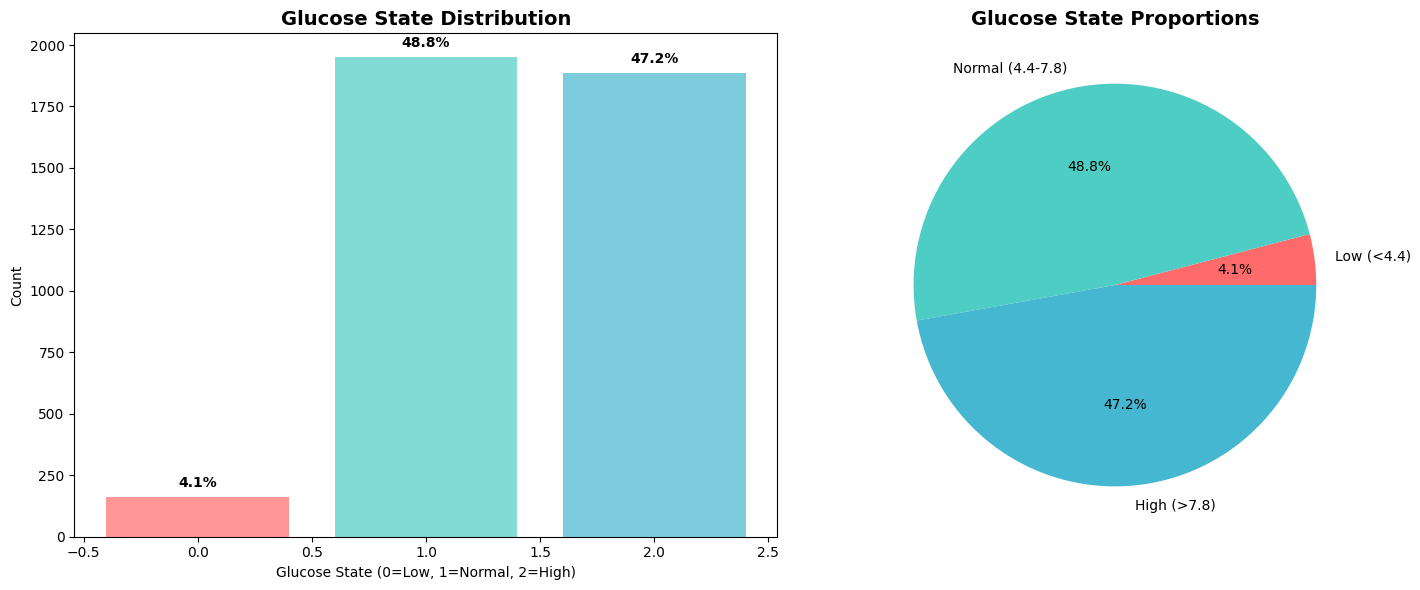

✅ Target distribution visualization displayed


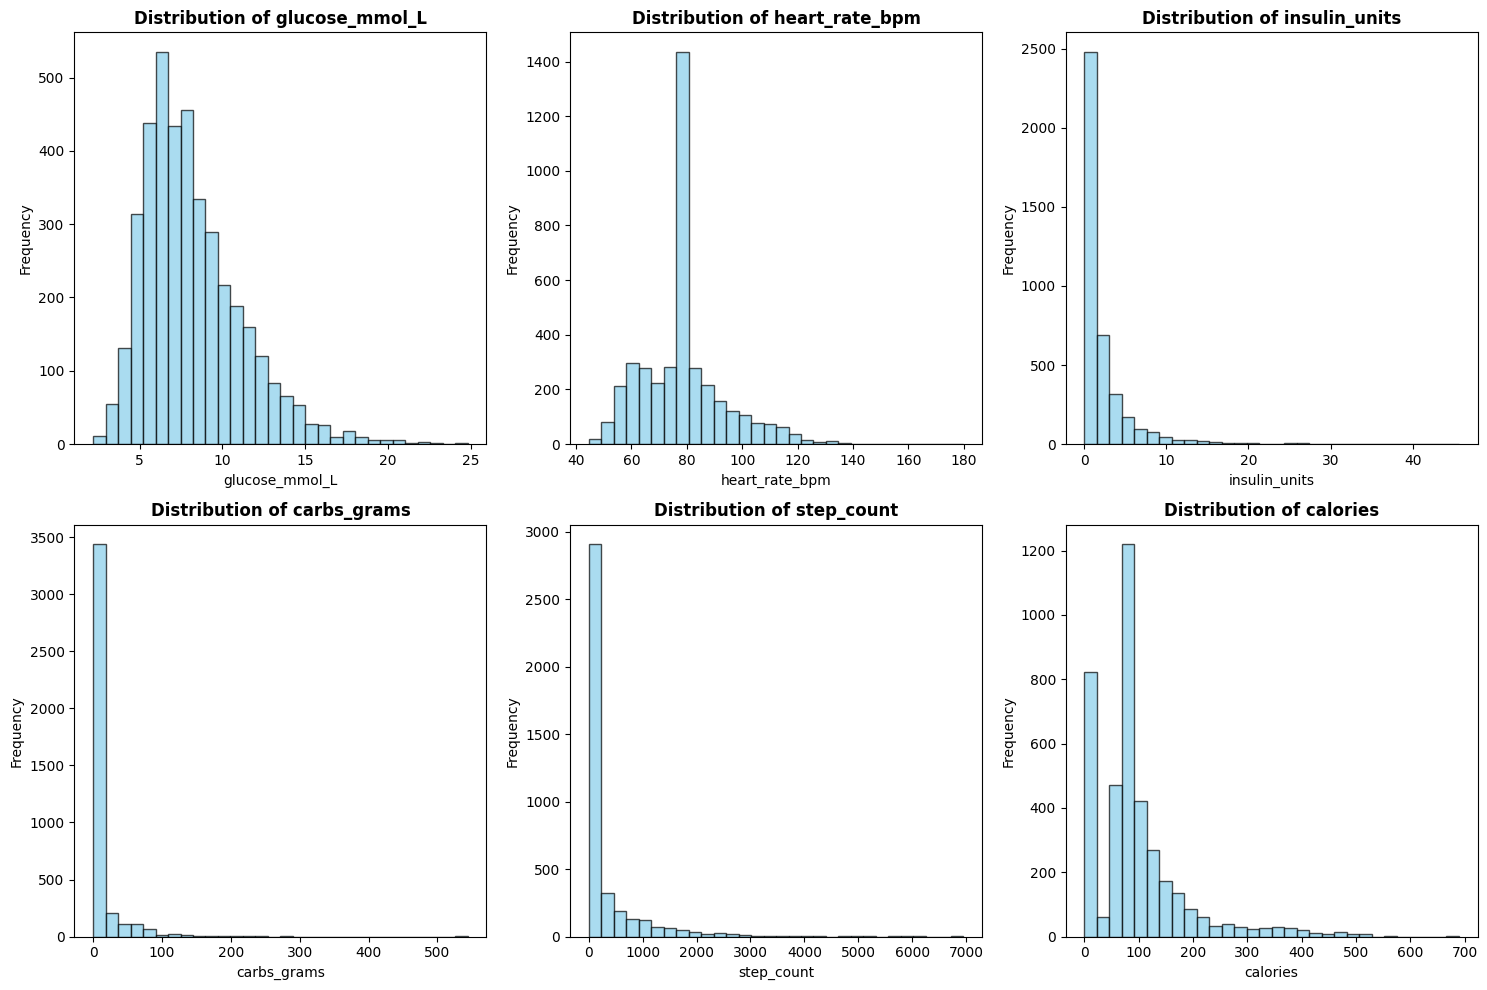

✅ Numeric features distribution visualization displayed


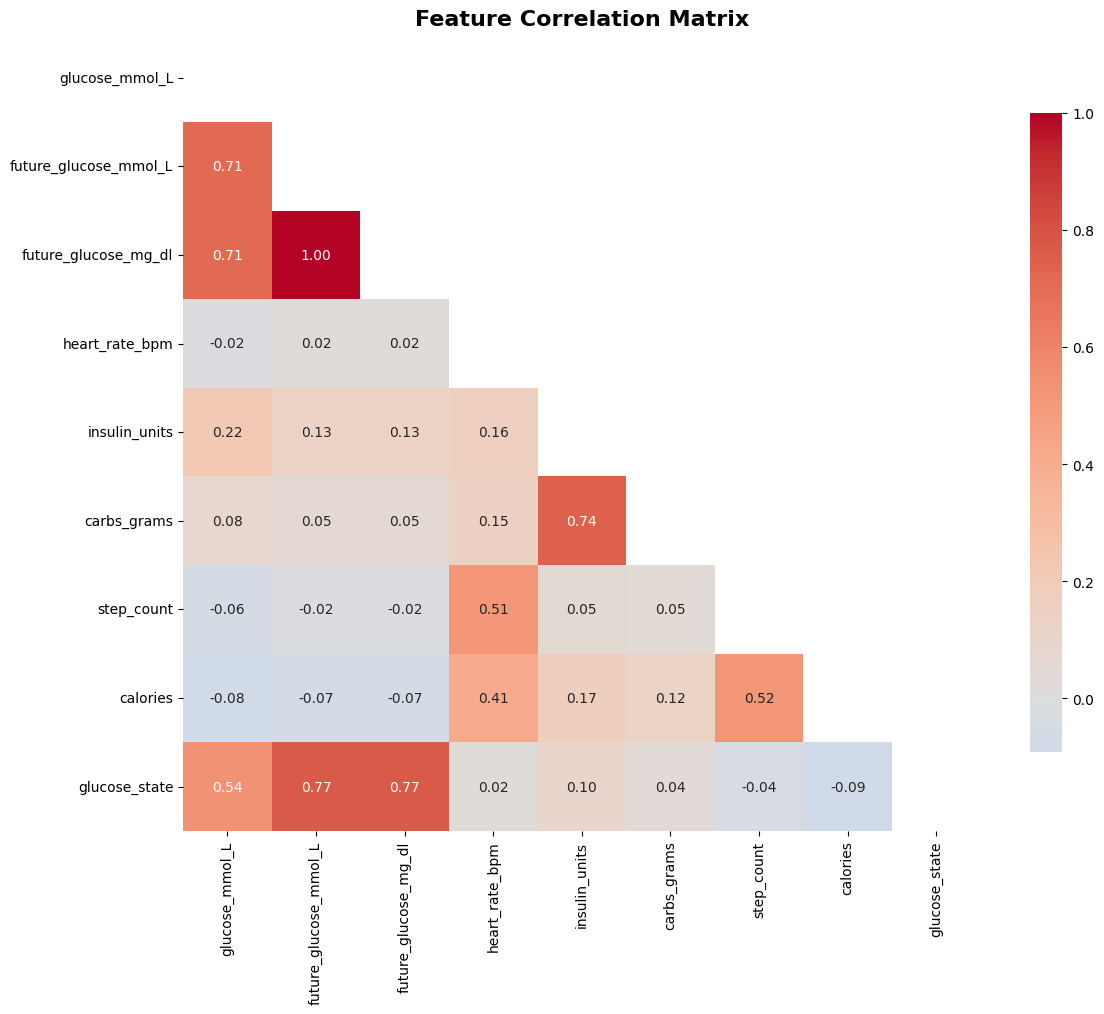

✅ Correlation heatmap displayed


glucose_state            1.000000
future_glucose_mg_dl     0.773650
future_glucose_mmol_L    0.773650
glucose_mmol_L           0.536291
insulin_units            0.096828
carbs_grams              0.037364
heart_rate_bpm           0.016158
step_count              -0.043522
calories                -0.090691
Name: glucose_state, dtype: float64

🎨 EDA visualizations complete!
🔧 Preprocessing data and engineering features...
✅ Preprocessing complete: 13 features
Features: ['glucose_mmol_L', 'heart_rate_bpm', 'insulin_units', 'carbs_grams', 'step_count', 'calories', 'insulin_given', 'log_carbs', 'log_steps', 'hr_glucose_interaction', 'hour_sin', 'hour_cos', 'activity_type']


,insulin_given,log_carbs,log_steps,hr_glucose_interaction,hour_sin,hour_cos
count,4000.000000,4000.000000,4000.000000,4000.000000,4.000000e+03,4.000000e+03
mean,0.931500,0.599032,2.840274,639.067050,2.859553e-02,1.396020e-02
std,0.252634,1.400184,2.907352,261.290227,7.122797e-01,7.013522e-01
min,0.000000,0.000000,0.000000,116.820000,-1.000000e+00,-1.000000e+00
25%,1.000000,0.000000,0.000000,449.500000,-7.071068e-01,-7.071068e-01
50%,1.000000,0.000000,2.302585,593.100000,1.224647e-16,6.123234e-17
75%,1.000000,0.000000,5.677609,772.582500,7.071068e-01,7.071068e-01
max,1.000000,6.300786,8.846497,2278.000000,1.000000e+00,1.000000e+00


📊 Processed data shape: (4000, 13)


,glucose_mmol_L,heart_rate_bpm,insulin_units,carbs_grams,step_count,calories,insulin_given,log_carbs,log_steps,hr_glucose_interaction,hour_sin,hour_cos,activity_type
0,6.7,83.0,25.0250,125.0,0.0,0.00,1,4.836282,0.000000,556.10,-0.707107,0.707107,Hike
1,5.2,95.2,4.7579,0.0,483.0,84.03,1,0.000000,6.182085,495.04,0.707107,-0.707107,Bike
2,5.7,75.7,2.5567,30.0,1414.0,207.42,1,3.433987,7.254885,431.49,-0.866025,-0.500000,Swim
3,3.3,102.6,0.3590,0.0,114.0,109.35,1,0.000000,4.744932,338.58,-0.866025,0.500000,Swimming
4,7.8,77.5,0.8477,0.0,0.0,74.34,1,0.000000,0.000000,604.50,0.258819,-0.965926,Spinning


✅ Data preprocessing complete!
🎯 Creating train-validation split with patient grouping...
✅ Group-based train-validation split created
   Unique patients in train: 7
📈 Training set: 2859 samples
📊 Validation set: 1141 samples


,Dataset,Samples,Features
0,Training,2859,13
1,Validation,1141,13


⚙️ Building preprocessing pipeline...
🔢 Numeric features (12): ['glucose_mmol_L', 'heart_rate_bpm', 'insulin_units', 'carbs_grams', 'step_count', 'calories', 'insulin_given', 'log_carbs', 'log_steps', 'hr_glucose_interaction', 'hour_sin', 'hour_cos']
📝 Categorical features (1): ['activity_type']
✅ Preprocessor pipeline built!


AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [17]:
# %%
print("📈 Creating EDA visualizations...")

def create_eda_visualizations(df):
    """Create comprehensive EDA visualizations in notebook"""
    
    # 1. Target variable distribution
    if "glucose_state" in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Count plot
        glucose_counts = df["glucose_state"].value_counts().sort_index()
        bars = axes[0].bar(glucose_counts.index, glucose_counts.values, 
                          color=['#ff6b6b', '#4ecdc4', '#45b7d1'], alpha=0.7)
        axes[0].set_title('Glucose State Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Glucose State (0=Low, 1=Normal, 2=High)')
        axes[0].set_ylabel('Count')
        
        # Add percentage labels
        total = len(df)
        for i, count in enumerate(glucose_counts.values):
            axes[0].text(glucose_counts.index[i], count + total*0.01, 
                        f'{count/total:.1%}', ha='center', fontweight='bold')
        
        # Pie chart
        labels = ['Low (<4.4)', 'Normal (4.4-7.8)', 'High (>7.8)']
        axes[1].pie(glucose_counts.values, labels=labels, autopct='%1.1f%%', 
                   colors=['#ff6b6b', '#4ecdc4', '#45b7d1'])
        axes[1].set_title('Glucose State Proportions', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        print("✅ Target distribution visualization displayed")
    
    # 2. Numeric features distribution
    numeric_features = ["glucose_mmol_L", "heart_rate_bpm", "insulin_units", 
                       "carbs_grams", "step_count", "calories"]
    numeric_features = [col for col in numeric_features if col in df.columns]
    
    if numeric_features:
        n_cols = 3
        n_rows = (len(numeric_features) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else axes
        
        for i, feature in enumerate(numeric_features):
            if i < len(axes):
                axes[i].hist(df[feature].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
                axes[i].set_title(f'Distribution of {feature}', fontweight='bold')
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Frequency')
        
        # Remove empty subplots
        for i in range(len(numeric_features), len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
        print("✅ Numeric features distribution visualization displayed")
    
    # 3. Correlation heatmap
    numeric_cols_for_corr = [col for col in df.select_dtypes(include=[np.number]).columns 
                           if col in df.columns and col != 'glucose_state']
    if len(numeric_cols_for_corr) > 1 and 'glucose_state' in df.columns:
        corr_matrix = df[numeric_cols_for_corr + ['glucose_state']].corr()
        
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("✅ Correlation heatmap displayed")
        
        # Display correlation with target
        if 'glucose_state' in corr_matrix.columns:
            display(HTML("<h4>Correlation with Glucose State</h4>"))
            target_corr = corr_matrix['glucose_state'].sort_values(ascending=False)
            display(target_corr)

# Generate EDA visualizations
create_eda_visualizations(df)
print("🎨 EDA visualizations complete!")

# %% [markdown]
# ## 5. Data Preprocessing and Feature Engineering

# %%
print("🔧 Preprocessing data and engineering features...")

def preprocess(df, is_train=True):
    # Make a copy
    df = df.copy()

    # Parse timestamp -> hour, minute as cyclic features
    if "timestamp" in df.columns:
        t = pd.to_datetime(df["timestamp"], errors="coerce")
        df["hour"] = t.dt.hour.fillna(0).astype(int)
        df["minute"] = t.dt.minute.fillna(0).astype(int)
        # cyclic encoding for hour (24h)
        df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
        df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    else:
        df["hour"] = 0
        df["minute"] = 0
        df["hour_sin"] = 0.0
        df["hour_cos"] = 0.0

    # Numeric features to consider (ensure they exist)
    numeric_features = [
        "glucose_mmol_L", "heart_rate_bpm", "insulin_units", "carbs_grams", 
        "step_count", "calories", "hour_sin", "hour_cos"
    ]
    for c in numeric_features:
        if c not in df.columns:
            df[c] = 0.0

    # Feature engineering
    df["insulin_given"] = (df["insulin_units"].fillna(0) > 0).astype(int)
    df["log_carbs"] = np.log1p(df["carbs_grams"].fillna(0))
    df["log_steps"] = np.log1p(df["step_count"].fillna(0))
    
    hr_median = df["heart_rate_bpm"].median() if not df["heart_rate_bpm"].isna().all() else 0
    glucose_median = df["glucose_mmol_L"].median() if not df["glucose_mmol_L"].isna().all() else 0
    df["hr_glucose_interaction"] = (
        df["heart_rate_bpm"].fillna(hr_median) * df["glucose_mmol_L"].fillna(glucose_median)
    )

    # Categorical: activity_type
    if "activity_type" in df.columns:
        df["activity_type"] = df["activity_type"].fillna("Unknown").astype(str)
    else:
        df["activity_type"] = "Unknown"

    # Fill missing numeric values with medians
    numeric_fill_cols = [
        "glucose_mmol_L","heart_rate_bpm","insulin_units","carbs_grams",
        "step_count","calories","log_carbs","log_steps","hr_glucose_interaction"
    ]
    for col in numeric_fill_cols:
        if col in df.columns and not df[col].isna().all():
            df[col] = df[col].fillna(df[col].median())
        elif col in df.columns:
            df[col] = 0.0

    # For training, ensure target exists
    if is_train:
        if "glucose_state" not in df.columns:
            raise ValueError("Training dataframe missing glucose_state target column")
        if df["glucose_state"].isna().any():
            print("⚠️ Warning: NaN values found in glucose_state. Dropping rows with NaN target.")
            df = df.dropna(subset=["glucose_state"])
        y = df["glucose_state"].astype(int)
    else:
        y = None

    # Select features
    base_feature_cols = [
        "glucose_mmol_L","heart_rate_bpm","insulin_units","carbs_grams",
        "step_count","calories","insulin_given","log_carbs","log_steps",
        "hr_glucose_interaction","hour_sin","hour_cos","activity_type"
    ]
    
    feature_cols = [col for col in base_feature_cols if col in df.columns]
    X = df[feature_cols].copy()
    
    print(f"✅ Preprocessing complete: {len(feature_cols)} features")
    print(f"Features: {feature_cols}")
    
    # Display engineered features info
    if is_train:
        display(HTML("<h4>Engineered Features Summary</h4>"))
        engineered_features = ['insulin_given', 'log_carbs', 'log_steps', 'hr_glucose_interaction', 'hour_sin', 'hour_cos']
        available_engineered = [f for f in engineered_features if f in X.columns]
        
        if available_engineered:
            engineered_summary = X[available_engineered].describe()
            display(engineered_summary)
    
    return X, y, df

# Preprocess the data
X, y, df_full = preprocess(df, is_train=True)

if len(X) == 0:
    print("❌ Error: No data available after preprocessing.")
    exit()

print(f"📊 Processed data shape: {X.shape}")
display(HTML("<h4>Final Feature Matrix</h4>"))
display(X.head())
print("✅ Data preprocessing complete!")

# %% [markdown]
# ## 6. Train-Validation Split with Patient Grouping

# %%
print("🎯 Creating train-validation split with patient grouping...")

if "patient_id" not in df_full.columns:
    print("⚠️ Warning: patient_id column not found. Using random split instead.")
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    groups_train = None
    print("✅ Random train-test split created")
else:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    groups = df_full["patient_id"].values
    train_idx, val_idx = next(gss.split(X, y, groups=groups))
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    groups_train = groups[train_idx]
    print("✅ Group-based train-validation split created")
    print(f"   Unique patients in train: {len(np.unique(groups_train))}")

print(f"📈 Training set: {X_train.shape[0]} samples")
print(f"📊 Validation set: {X_val.shape[0]} samples")

# Display split summary
split_summary = pd.DataFrame({
    'Dataset': ['Training', 'Validation'],
    'Samples': [X_train.shape[0], X_val.shape[0]],
    'Features': [X_train.shape[1], X_val.shape[1]]
})
display(HTML("<h4>Train-Validation Split Summary</h4>"))
display(split_summary)

if len(X_train) == 0 or len(X_val) == 0:
    print("❌ Error: Not enough data for training/validation split.")
    exit()

# %% [markdown]
# ## 7. Preprocessor Pipeline Construction

# %%
print("⚙️ Building preprocessing pipeline...")

# Identify numeric and categorical columns
numeric_cols = [c for c in X_train.columns if X_train[c].dtype in ['int64', 'float64'] and c != "activity_type"]
categorical_cols = ["activity_type"] if "activity_type" in X_train.columns else []

print(f"🔢 Numeric features ({len(numeric_cols)}): {numeric_cols}")
print(f"📝 Categorical features ({len(categorical_cols)}): {categorical_cols}")

def build_preprocessor(numeric_cols, categorical_cols):
    numeric_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ])
    return preprocessor

preprocessor = build_preprocessor(numeric_cols, categorical_cols)
print("✅ Preprocessor pipeline built!")

# Display pipeline structure
display(HTML("<h4>Preprocessing Pipeline Structure</h4>"))
print("Numeric Pipeline:", preprocessor.named_transformers_['num'])
print("Categorical Pipeline:", preprocessor.named_transformers_['cat'])

# %% [markdown]
# ## 8. Model Training and Baseline Evaluation

# %%
print("🤖 Training multiple machine learning models...")

models = {}

# Logistic Regression
try:
    print("📘 Training Logistic Regression...")
    pipe_lr = Pipeline([
        ("preproc", preprocessor),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
    ])
    pipe_lr.fit(X_train, y_train)
    models["LogisticRegression"] = pipe_lr
    print("✅ LogisticRegression trained")
except Exception as e:
    print(f"❌ LogisticRegression failed: {e}")

# Random Forest
try:
    print("🌲 Training Random Forest...")
    pipe_rf = Pipeline([
        ("preproc", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1))
    ])
    pipe_rf.fit(X_train, y_train)
    models["RandomForest"] = pipe_rf
    print("✅ RandomForest trained")
except Exception as e:
    print(f"❌ RandomForest failed: {e}")

# Gradient Boosting
try:
    print("🚀 Training Gradient Boosting...")
    pipe_gb = Pipeline([
        ("preproc", preprocessor),
        ("clf", GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
    pipe_gb.fit(X_train, y_train)
    models["GradientBoosting"] = pipe_gb
    print("✅ GradientBoosting trained")
except Exception as e:
    print(f"❌ GradientBoosting failed: {e}")

print(f"✅ Model training complete! {len(models)} models trained successfully")

# Display model training summary
display(HTML("<h4>Model Training Summary</h4>"))
model_summary = pd.DataFrame({
    'Model': list(models.keys()),
    'Status': ['Trained' for _ in models],
    'Pipeline Steps': [len(model.named_steps) for model in models.values()]
})
display(model_summary)

# %% [markdown]
# ## 9. Model Evaluation and Performance Visualization

# %%
print("📊 Evaluating model performance...")

def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    display(HTML(f"<h4>{model_name} Performance</h4>"))
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report as DataFrame
    report = classification_report(y_val, y_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)
    
    return y_pred, accuracy

# Evaluate each model
model_performance = {}
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Evaluating {name}:")
    print('='*50)
    y_pred, accuracy = evaluate_model(model, X_val, y_val, name)
    model_performance[name] = accuracy

def create_model_performance_visualizations(models, X_val, y_val):
    """Create comprehensive model performance visualizations in notebook"""
    
    # 1. Confusion matrices
    n_models = len(models)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (name, model) in enumerate(models.items()):
        if idx < len(axes):
            y_pred = model.predict(X_val)
            cm = confusion_matrix(y_val, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       xticklabels=['Low', 'Normal', 'High'], 
                       yticklabels=['Low', 'Normal', 'High'])
            accuracy = accuracy_score(y_val, y_pred)
            axes[idx].set_title(f'{name}\nAccuracy: {accuracy:.3f}', fontweight='bold')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')
    
    # Remove empty subplots
    for idx in range(len(models), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    # 2. Model comparison bar chart
    model_names = list(models.keys())
    accuracies = [accuracy_score(y_val, model.predict(X_val)) for model in models.values()]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Display performance summary table
    performance_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracies
    }).sort_values('Accuracy', ascending=False)
    
    display(HTML("<h4>Model Performance Summary</h4>"))
    display(performance_df)

# Create performance visualizations
create_model_performance_visualizations(models, X_val, y_val)
print("✅ Model performance evaluation complete!")

# %% [markdown]
# ## 10. Cross-Validation and Hyperparameter Tuning

# %%
print("🎛️ Performing cross-validation and hyperparameter tuning...")

# Cross-validation for RandomForest
if 'RandomForest' in models and groups_train is not None:
    try:
        print("\n🔍 Performing Group Cross-Validation (RandomForest)...")
        gkf = GroupKFold(n_splits=min(5, len(np.unique(groups_train))))
        rf_pipe = models["RandomForest"]
        cv_scores = cross_val_score(rf_pipe, X_train, y_train, cv=gkf, groups=groups_train, scoring="f1_macro", n_jobs=1)
        
        cv_results = pd.DataFrame({
            'Fold': range(1, len(cv_scores) + 1),
            'F1_Score': cv_scores
        })
        display(HTML("<h4>Cross-Validation Results (RandomForest)</h4>"))
        display(cv_results)
        print(f"Mean CV F1-score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
    except Exception as e:
        print(f"❌ Cross-validation failed: {e}")

# Hyperparameter tuning for RandomForest
best_rf = None
if 'RandomForest' in models and groups_train is not None:
    try:
        print("\n⚡ Tuning RandomForest hyperparameters...")
        param_grid = {
            "clf__n_estimators": [50, 100],
            "clf__max_depth": [None, 10],
            "clf__min_samples_split": [2, 5]
        }
        gkf = GroupKFold(n_splits=min(3, len(np.unique(groups_train))))
        grid = GridSearchCV(models["RandomForest"], param_grid=param_grid, cv=gkf, scoring="f1_macro", n_jobs=1, verbose=1)
        grid.fit(X_train, y_train, groups=groups_train)
        
        # Display tuning results
        tuning_results = pd.DataFrame(grid.cv_results_)
        display(HTML("<h4>Hyperparameter Tuning Results</h4>"))
        display(tuning_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score'))
        
        print(f"✅ Best parameters: {grid.best_params_}")
        print(f"✅ Best CV score: {grid.best_score_:.4f}")
        
        best_rf = grid.best_estimator_
        print("\n📊 Validation performance of tuned RandomForest:")
        evaluate_model(best_rf, X_val, y_val, "Tuned RandomForest")
        
    except Exception as e:
        print(f"❌ Hyperparameter tuning failed: {e}")
        best_rf = models.get("RandomForest")
else:
    best_rf = models.get("RandomForest")

print("✅ Cross-validation and tuning complete!")

# %% [markdown]
# ## 11. Ensemble Model Creation

# %%
print("👥 Creating ensemble model...")

voting = None
if len(models) >= 2:
    try:
        print("🤝 Building Voting Classifier ensemble...")
        estimators = [(name, model) for name, model in models.items()]
        voting = VotingClassifier(estimators=estimators, voting="soft", n_jobs=-1)
        voting.fit(X_train, y_train)
        print("✅ Voting ensemble trained")
        print("\n📊 Voting ensemble evaluation:")
        evaluate_model(voting, X_val, y_val, "Voting Ensemble")
    except Exception as e:
        print(f"❌ Ensemble creation failed: {e}")
        voting = list(models.values())[0]
else:
    voting = list(models.values())[0]

# Choose best model
best_model = voting if voting is not None else (best_rf if best_rf is not None else list(models.values())[0])
print(f"✅ Best model selected: {type(best_model).__name__}")

# Display final model selection
display(HTML("<h4>Final Model Selection</h4>"))
final_model_info = pd.DataFrame({
    'Model Type': [type(best_model).__name__],
    'Base Models': [', '.join(models.keys()) if hasattr(best_model, 'estimators') else 'Single Model'],
    'Validation Accuracy': [accuracy_score(y_val, best_model.predict(X_val))]
})
display(final_model_info)

# %% [markdown]
# ## 12. Model Interpretability with SHAP

# %%
print("🔍 Generating model interpretability analysis...")

def safe_shap_analysis(model, preprocessor, X_train, numeric_cols, categorical_cols):
    """Safe SHAP analysis with comprehensive error handling"""
    try:
        rf_clf = None
        rf_preproc = None
        
        if hasattr(model, 'named_steps') and 'clf' in model.named_steps:
            rf_clf = model.named_steps["clf"]
            rf_preproc = model.named_steps["preproc"]
        else:
            rf_clf = model
            rf_preproc = preprocessor

        if rf_clf is None or rf_preproc is None:
            print("❌ SHAP: Could not extract classifier or preprocessor")
            return

        if not hasattr(rf_clf, 'estimators_'):
            print("⚠️ SHAP: Model is not tree-based, skipping SHAP analysis")
            return

        # Build transformed training sample for SHAP
        sample_size = min(500, len(X_train))
        X_shap_sample = X_train.sample(n=sample_size, random_state=42)
        X_shap_trans = rf_preproc.transform(X_shap_sample)
        
        # Get feature names
        feature_names = []
        feature_names.extend(numeric_cols)
        
        try:
            if hasattr(rf_preproc, 'named_transformers_') and 'cat' in rf_preproc.named_transformers_:
                ohe = rf_preproc.named_transformers_["cat"].named_steps["onehot"]
                cat_names = list(ohe.get_feature_names_out(categorical_cols))
                feature_names.extend(cat_names)
        except Exception as e:
            print(f"⚠️ SHAP: Could not get categorical feature names: {e}")

        print("📊 Creating SHAP explanations...")
        explainer = shap.TreeExplainer(rf_clf)
        shap_values = explainer.shap_values(X_shap_trans)
        
        # Feature importance plot
        plt.figure(figsize=(10, 8))
        if isinstance(shap_values, list):
            shap.summary_plot(shap_values, X_shap_trans, feature_names=feature_names, show=False)
        else:
            shap.summary_plot(shap_values, X_shap_trans, feature_names=feature_names, show=False)
        plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Display feature importance as table
        if isinstance(shap_values, list):
            # For multi-class, use mean absolute SHAP values across classes
            mean_abs_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
        else:
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
        
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean |SHAP|': mean_abs_shap
        }).sort_values('Mean |SHAP|', ascending=False)
        
        display(HTML("<h4>Feature Importance (SHAP Values)</h4>"))
        display(feature_importance_df.head(10))
        
        print("✅ SHAP analysis complete!")
        
    except Exception as e:
        print(f"❌ SHAP analysis failed: {e}")

# Perform SHAP analysis if we have a tree-based model
if best_rf is not None:
    safe_shap_analysis(best_rf, preprocessor, X_train, numeric_cols, categorical_cols)
else:
    print("⚠️ Skipping SHAP analysis - no suitable tree-based model available")

# %% [markdown]
# ## 13. Deployment Simulation and Prediction

# %%
print("🚀 Running deployment simulation on test data...")

def create_prediction_visualizations(predictions_df):
    """Create visualizations for predictions in notebook"""
    
    # Prediction distribution
    if 'pred_class_name' in predictions_df.columns:
        plt.figure(figsize=(10, 6))
        pred_counts = predictions_df['pred_class_name'].value_counts()
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
        bars = plt.bar(pred_counts.index, pred_counts.values, color=colors, alpha=0.7)
        plt.title('Prediction Distribution on Test Set', fontsize=14, fontweight='bold')
        plt.ylabel('Count')
        
        # Add percentage labels
        total = len(predictions_df)
        for bar, count in zip(bars, pred_counts.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01,
                    f'{count/total:.1%}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

try:
    # Load test data
    test_df = load_data(TEST_CSV)
    X_test, _, test_full = preprocess(test_df, is_train=False)
    
    # Make predictions using the best model
    preds = best_model.predict(X_test)
    preds_proba = None
    if hasattr(best_model, "predict_proba"):
        preds_proba = best_model.predict_proba(X_test)
    
    # Map labels
    label_map = {0: "Low(<4.4 mmol/L)", 1: "Normal(4.4-7.8 mmol/L)", 2: "High(>7.8 mmol/L)"}
    pred_names = [label_map.get(int(p), str(p)) for p in preds]
    
    # Create predictions dataframe
    out = test_full.reset_index(drop=True)
    out["pred_class"] = preds
    out["pred_class_name"] = pred_names
    if preds_proba is not None:
        for cls in range(preds_proba.shape[1]):
            out[f"proba_class_{cls}"] = preds_proba[:, cls]
    
    # Display predictions
    display(HTML("<h4>Test Set Predictions</h4>"))
    print(f"📊 Generated predictions for {len(out)} test samples")
    
    # Show detailed predictions
    cols_to_show = [c for c in ["patient_id","timestamp","glucose_mmol_L","pred_class","pred_class_name"] if c in out.columns]
    if preds_proba is not None:
        proba_cols = [f"proba_class_{cls}" for cls in range(preds_proba.shape[1])]
        cols_to_show.extend(proba_cols)
    
    display(HTML("<b>First 10 predictions:</b>"))
    display(out[cols_to_show].head(10))
    
    # Create prediction visualizations
    create_prediction_visualizations(out)
    
    # Display prediction summary
    display(HTML("<h4>Prediction Summary</h4>"))
    pred_summary = out['pred_class_name'].value_counts().reset_index()
    pred_summary.columns = ['Glucose State', 'Count']
    pred_summary['Percentage'] = (pred_summary['Count'] / len(out) * 100).round(1)
    display(pred_summary)
    
except Exception as e:
    print(f"❌ Deployment simulation failed: {e}")

# %% [markdown]
# ## 14. Pipeline Summary and Results

# %%
print("\n" + "="*60)
print("🎉 PIPELINE EXECUTION COMPLETE!")
print("="*60)

# Create final summary
final_summary_data = []

# Model Performance
for name, accuracy in model_performance.items():
    final_summary_data.append({'Category': 'Model Performance', 'Metric': f'{name} Accuracy', 'Value': f'{accuracy:.4f}'})

# Ensemble performance
if voting is not None:
    ensemble_accuracy = accuracy_score(y_val, voting.predict(X_val))
    final_summary_data.append({'Category': 'Model Performance', 'Metric': 'Ensemble Accuracy', 'Value': f'{ensemble_accuracy:.4f}'})

# Data Summary
final_summary_data.extend([
    {'Category': 'Data Summary', 'Metric': 'Training Samples', 'Value': f'{X_train.shape[0]}'},
    {'Category': 'Data Summary', 'Metric': 'Validation Samples', 'Value': f'{X_val.shape[0]}'},
    {'Category': 'Data Summary', 'Metric': 'Features', 'Value': f'{X_train.shape[1]}'}
])

# Prediction Summary
if 'out' in locals():
    pred_counts = out['pred_class_name'].value_counts()
    for class_name, count in pred_counts.items():
        percentage = count / len(out) * 100
        final_summary_data.append({
            'Category': 'Predictions', 
            'Metric': class_name, 
            'Value': f'{count} ({percentage:.1f}%)'
        })

final_summary = pd.DataFrame(final_summary_data)
display(HTML("<h2>Pipeline Execution Summary</h2>"))
display(final_summary)